In [ ]:
!pip install arch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from itertools import combinations


In [ ]:
# Wczytanie danych z plików CSV
wig = pd.read_csv('wig20_d.csv')
cac = pd.read_csv('^cac_d.csv')
dax = pd.read_csv('^dax_d.csv')
px = pd.read_csv('^px_d.csv')

# Wybór kolumn 'Data' i 'Zamkniecie'
wig = wig[['Data', 'Zamkniecie']]
cac = cac[['Data', 'Zamkniecie']]
dax = dax[['Data', 'Zamkniecie']]
px = px[['Data', 'Zamkniecie']]

# Ustalenie wspólnego zakresu dat
common_start = max(wig['Data'].min(), cac['Data'].min(), dax['Data'].min(), px['Data'].min())
common_end = min(wig['Data'].max(), cac['Data'].max(), dax['Data'].max(), px['Data'].max())

# Filtracja danych do wspólnego zakresu
wig = wig[(wig['Data'] >= common_start) & (wig['Data'] <= common_end)]
cac = cac[(cac['Data'] >= common_start) & (cac['Data'] <= common_end)]
dax = dax[(dax['Data'] >= common_start) & (dax['Data'] <= common_end)]
px = px[(px['Data'] >= common_start) & (px['Data'] <= common_end)]

# Konwersja 'Data' na datetime i ustawienie jako indeks
for df in [wig, cac, dax, px]:
    df['Data'] = pd.to_datetime(df['Data'])
    df.set_index('Data', inplace=True)


<ipython-input-80-b682afe37c59>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Data'] = pd.to_datetime(df['Data'])


In [ ]:
# Funkcja do obliczania logarytmicznych stóp zwrotu
def calculate_log_returns(df, column_name='Zamkniecie'):
    df['log_returns'] = np.log(df[column_name] / df[column_name].shift(1))
    df.dropna(inplace=True)
    return df

# Obliczanie stóp zwrotu dla wszystkich indeksów
wig = calculate_log_returns(wig)
cac = calculate_log_returns(cac)
dax = calculate_log_returns(dax)
px = calculate_log_returns(px)


<ipython-input-81-200530919900>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_returns'] = np.log(df[column_name] / df[column_name].shift(1))
<ipython-input-81-200530919900>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
# Definicja okresów czasowych
pre_covid = slice('2018-01-01', '2019-12-31')
covid = slice('2020-01-01', '2022-02-23')
war = slice('2022-02-24', '2024-12-31')

# Podział danych na okresy
wig_periods = {
    'przed_pandemia': wig.loc[pre_covid],
    'covid': wig.loc[covid],
    'wojna': wig.loc[war]
}
cac_periods = {
    'przed_pandemia': cac.loc[pre_covid],
    'covid': cac.loc[covid],
    'wojna': cac.loc[war]
}
dax_periods = {
    'przed_pandemia': dax.loc[pre_covid],
    'covid': dax.loc[covid],
    'wojna': dax.loc[war]
}
px_periods = {
    'przed_pandemia': px.loc[pre_covid],
    'covid': px.loc[covid],
    'wojna': px.loc[war]
}


In [ ]:
# Funkcja dopasowująca modele GARCH(1,1) i GJR-GARCH(1,1) z przeskalowaniem danych
def fit_garch_models(df, column_name='log_returns', scale=100):
    # Przeskalowanie danych
    scaled_data = df[column_name].dropna() * scale

    # GARCH(1,1)
    garch_model = arch_model(scaled_data, vol='Garch', p=1, q=1)
    garch_results = garch_model.fit(disp='off')
    garch_variance = garch_results.conditional_volatility / scale  # Odskaowanie wariancji

    # GJR-GARCH(1,1)
    gjrgarch_model = arch_model(scaled_data, vol='Garch', p=1, o=1, q=1)
    gjrgarch_results = gjrgarch_model.fit(disp='off')
    gjrgarch_variance = gjrgarch_results.conditional_volatility / scale  # Odskaowanie wariancji

    return garch_variance, gjrgarch_variance

# Dopasowanie modeli dla każdego okresu i rynku
variances = {}
for period in ['przed_pandemia', 'covid', 'wojna']:
    variances[period] = {
        'wig': fit_garch_models(wig_periods[period]),
        'cac': fit_garch_models(cac_periods[period]),
        'dax': fit_garch_models(dax_periods[period]),
        'px': fit_garch_models(px_periods[period])
    }


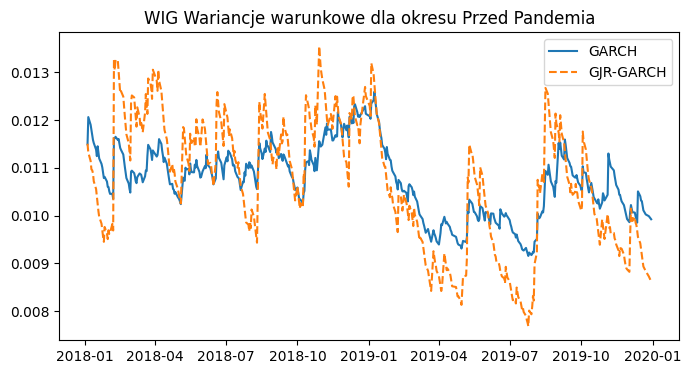

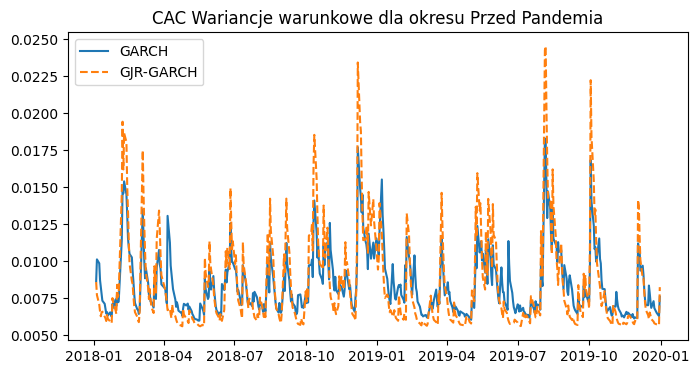

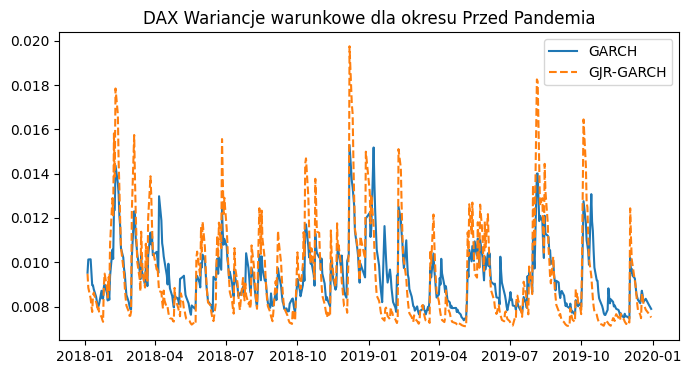

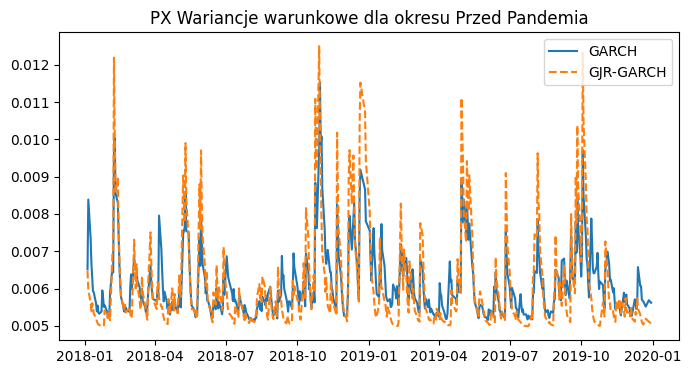

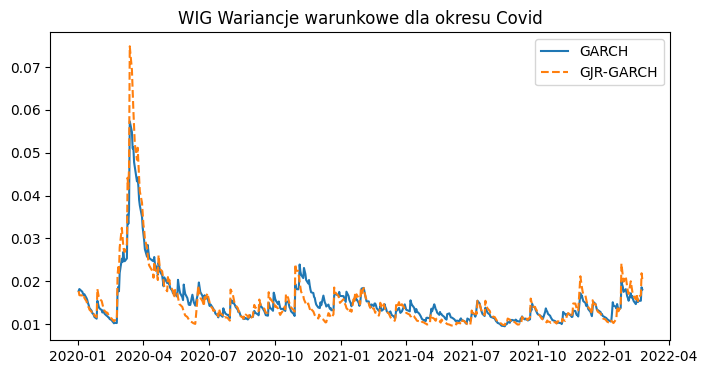

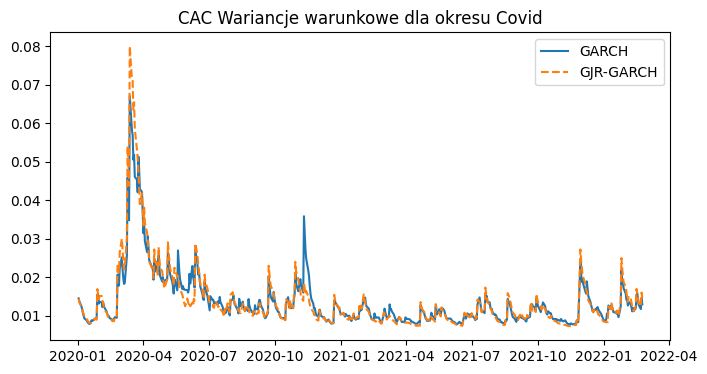

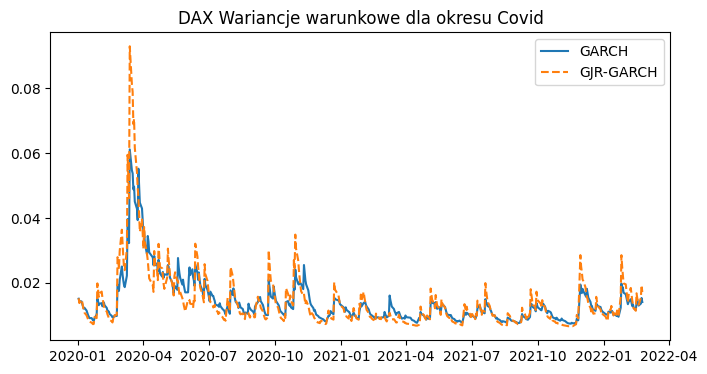

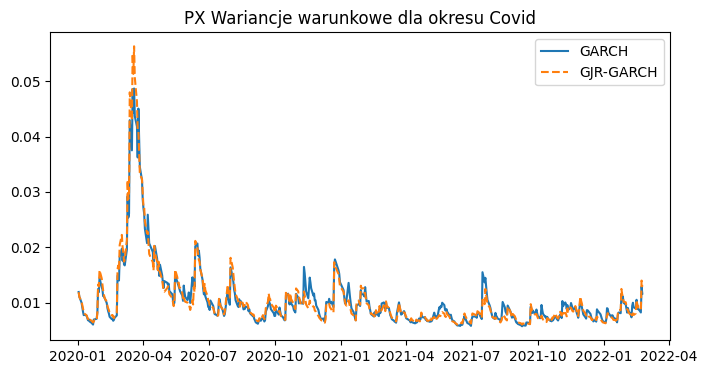

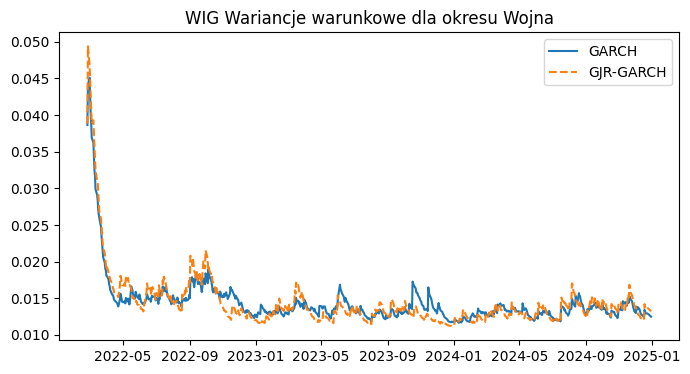

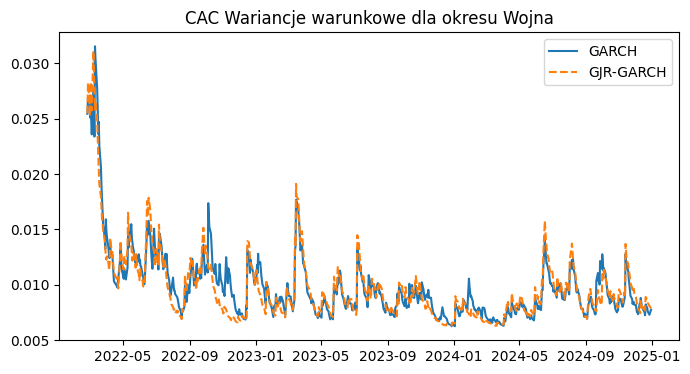

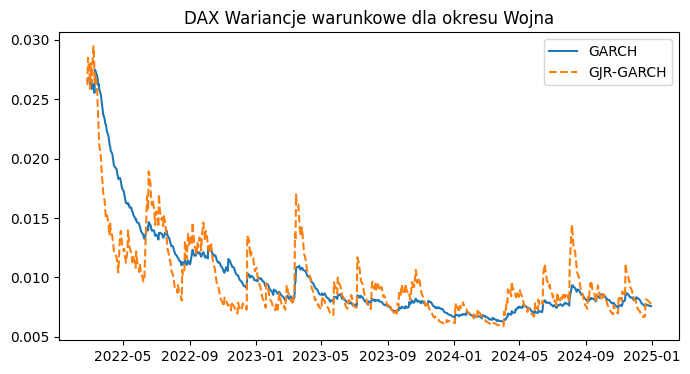

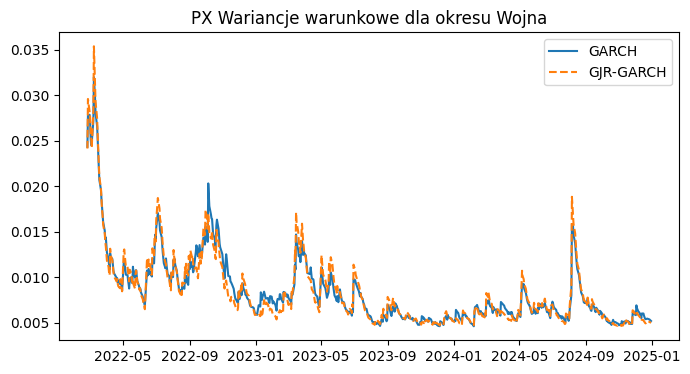

In [ ]:
# Wykresy dynamicznych wariancji i korelacji
for period in ['przed_pandemia', 'covid', 'wojna']:
    for market in ['wig', 'cac', 'dax', 'px']:
        plt.figure(figsize=(8, 4))
        plt.plot(variances[period][market][0], label='GARCH')
        plt.plot(variances[period][market][1], label='GJR-GARCH', linestyle='--')
        plt.title(f'{market.upper()} Wariancje warunkowe dla okresu {period.replace("_", " ").title()}')
        plt.legend()
        plt.show()


Scatter plots for Przed Pandemia


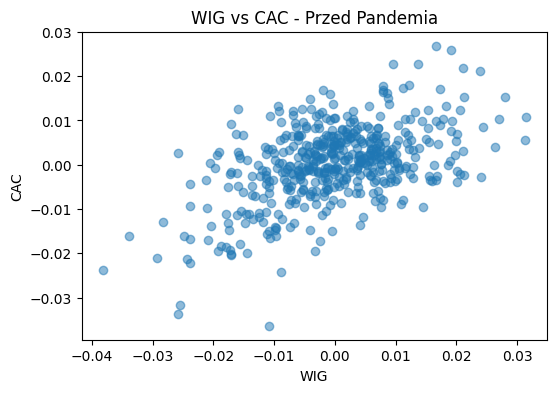

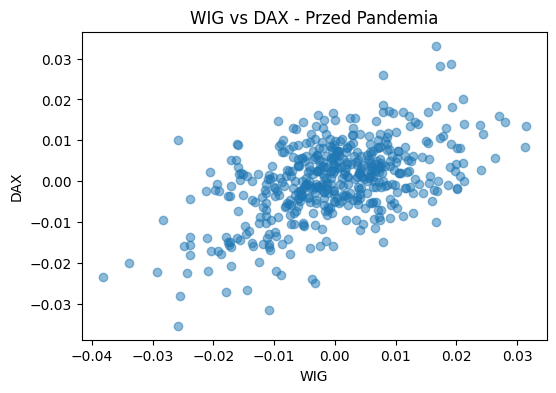

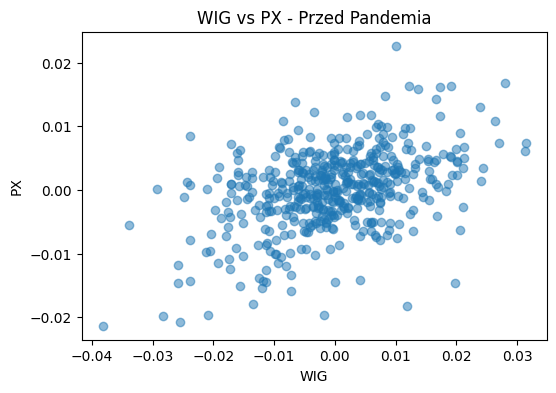

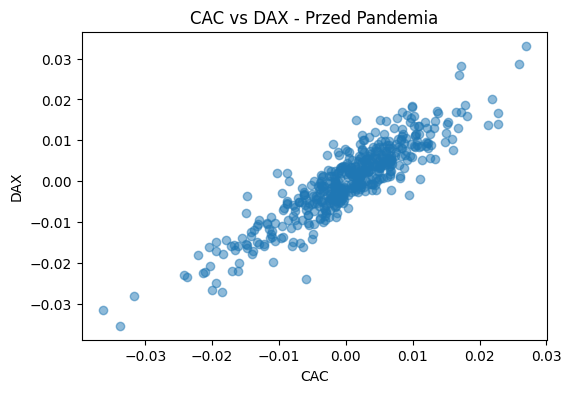

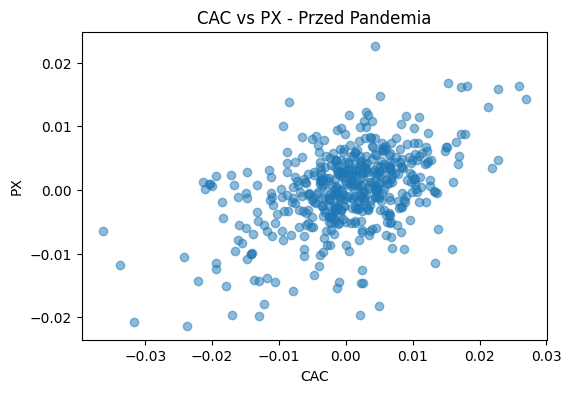

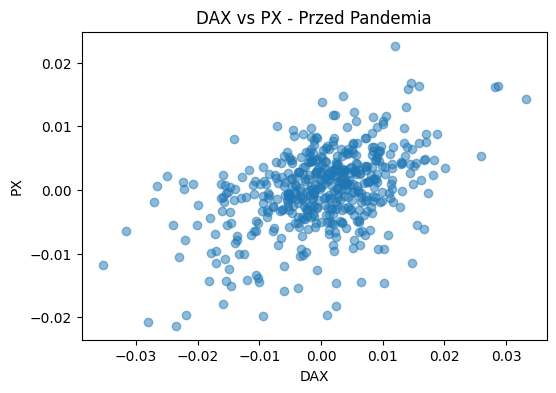

Scatter plots for Covid


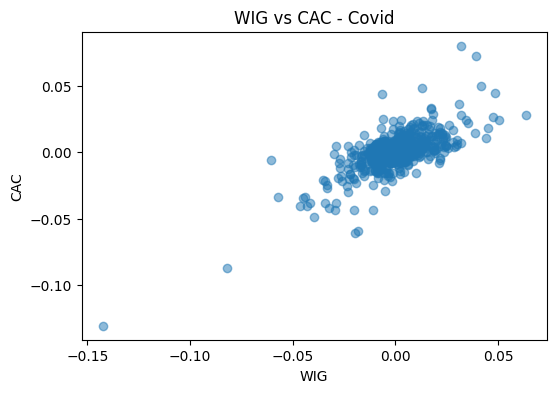

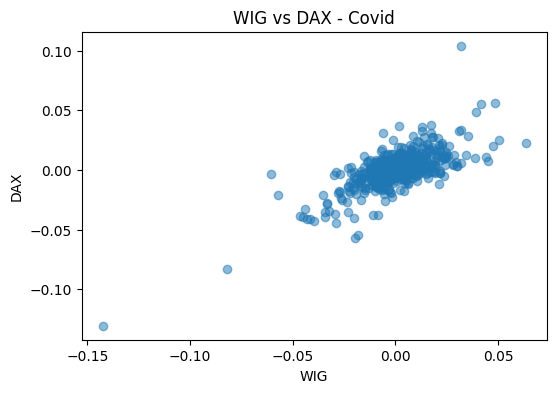

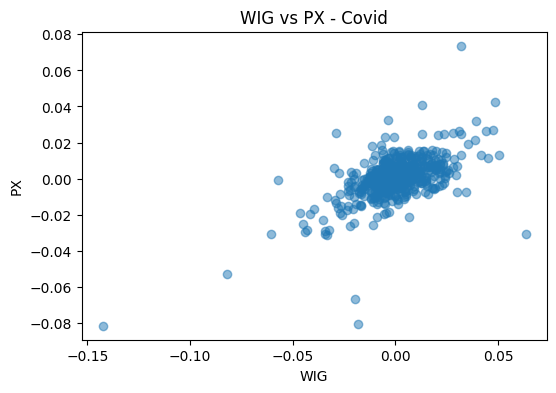

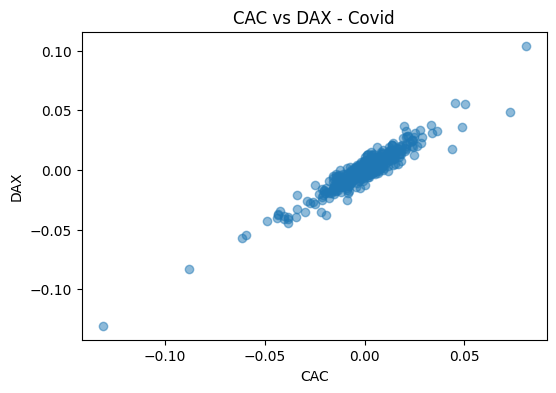

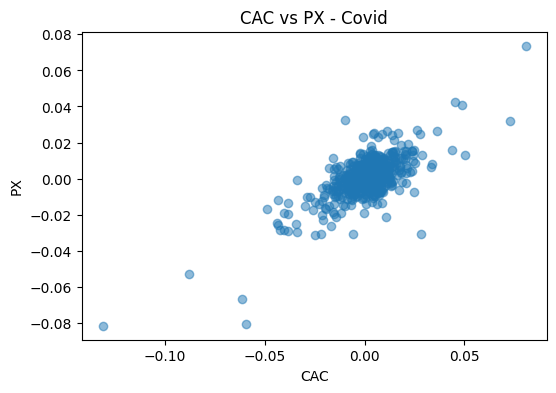

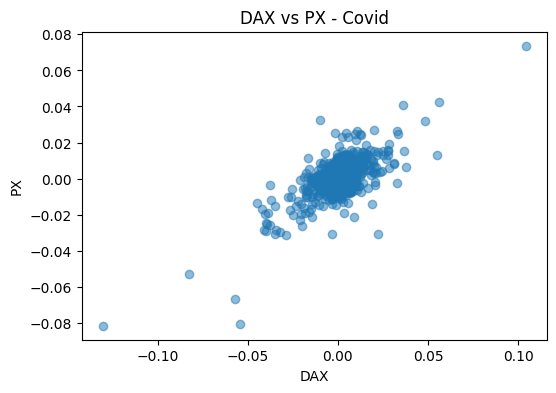

Scatter plots for Wojna


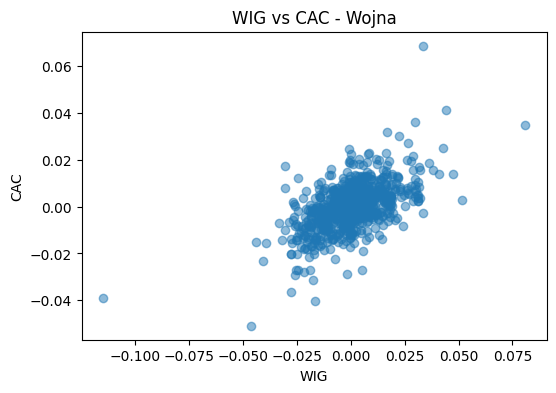

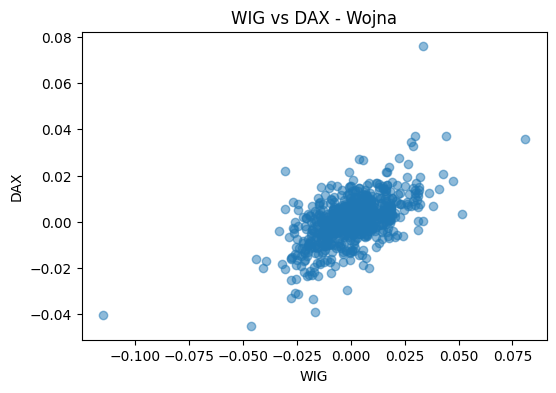

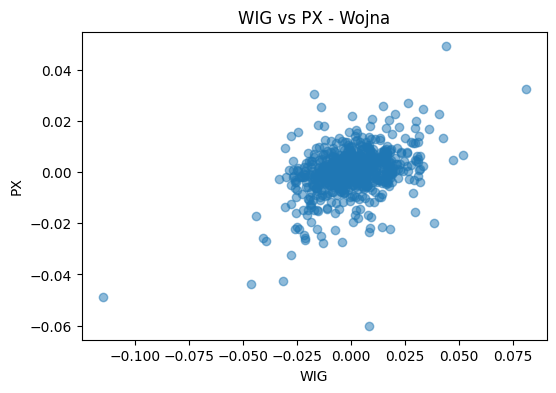

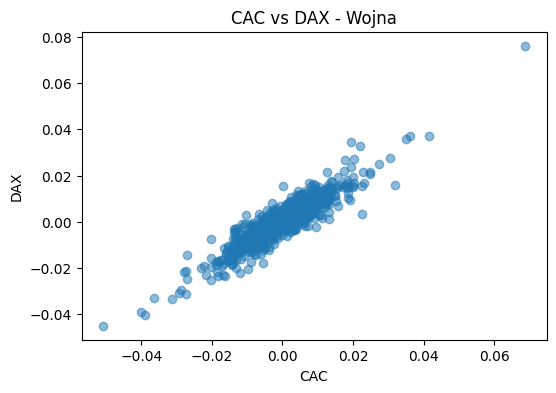

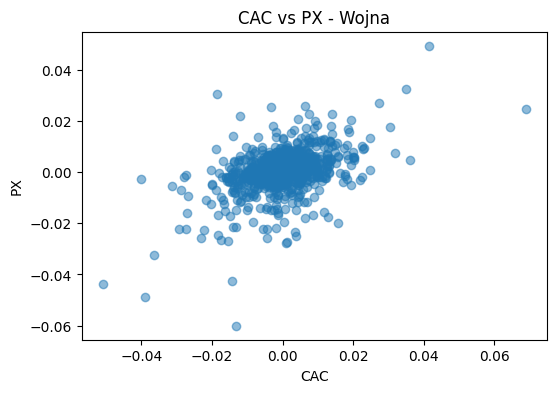

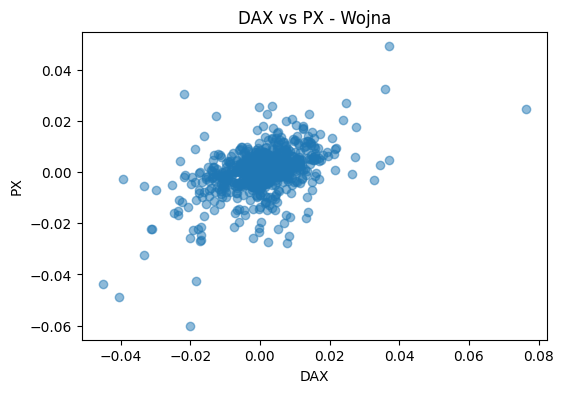

In [ ]:
# Porównanie rynków w parach z wyrównaniem indeksów
for period in ['przed_pandemia', 'covid', 'wojna']:
    print(f"Scatter plots for {period.replace('_', ' ').title()}")

    # Łączenie danych dla okresu i wyrównanie indeksów
    period_data = pd.concat(
        [wig_periods[period]['log_returns'],
         cac_periods[period]['log_returns'],
         dax_periods[period]['log_returns'],
         px_periods[period]['log_returns']],
        axis=1, join="inner"
    )
    period_data.columns = ['WIG', 'CAC', 'DAX', 'PX']

    # Generowanie wykresów dla każdej pary
    for pair in combinations(period_data.columns, 2):
        plt.figure(figsize=(6, 4))
        plt.scatter(period_data[pair[0]], period_data[pair[1]], alpha=0.5)
        plt.title(f'{pair[0]} vs {pair[1]} - {period.replace("_", " ").title()}')
        plt.xlabel(pair[0])
        plt.ylabel(pair[1])
        plt.show()


In [ ]:
# Funkcja do tworzenia tabel z podstawowymi statystykami
def generate_statistics(df, name):
    stats = df.describe()
    stats.loc['coefficient_of_variation'] = stats.loc['std'] / stats.loc['mean']
    print(f"\nStatistics for {name}:")
    print(stats)
    return stats

# Generowanie tabel dla każdego rynku i okresu
tables = {}
for period in ['przed_pandemia', 'covid', 'wojna']:
    tables[period] = {}
    for market, data in zip(['wig', 'cac', 'dax', 'px'], [wig, cac, dax, px]):
        stats = generate_statistics(data.loc[eval(period)], market)
        tables[period][market] = stats



Statistics for wig:
                           Zamkniecie  log_returns
count                      494.000000   494.000000
mean                      2270.201984    -0.000275
std                        107.907179     0.010789
min                       2047.340000    -0.038211
25%                       2189.677500    -0.006859
50%                       2272.010000    -0.000273
75%                       2332.890000     0.006788
max                       2630.370000     0.031388
coefficient_of_variation     0.047532   -39.198282

Statistics for cac:
                           Zamkniecie  log_returns
count                      508.000000   508.000000
mean                      5376.209449     0.000225
std                        277.005892     0.008557
min                       4598.610000    -0.036355
25%                       5241.527500    -0.003740
50%                       5405.425000     0.000865
75%                       5531.582500     0.005368
max                       6037.390000   

Correlations During Przed Pandemia
          WIG       CAC       DAX        PX
WIG  1.000000  0.506311  0.517730  0.432496
CAC  0.506311  1.000000  0.902793  0.465258
DAX  0.517730  0.902793  1.000000  0.450022
PX   0.432496  0.465258  0.450022  1.000000


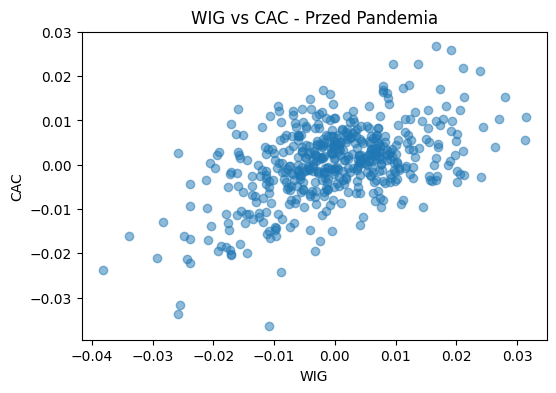

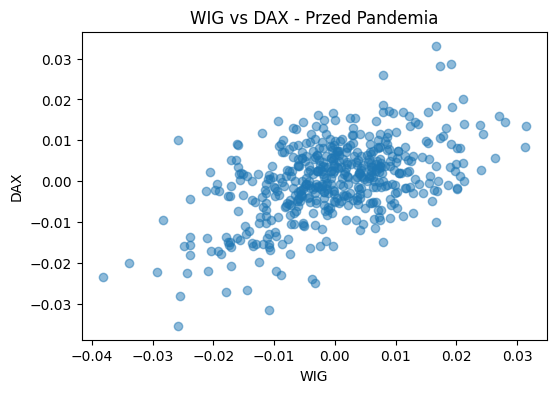

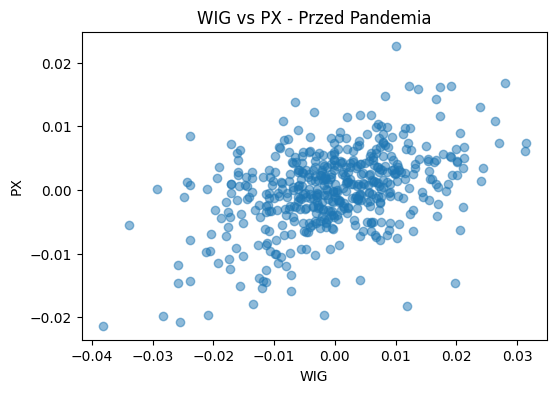

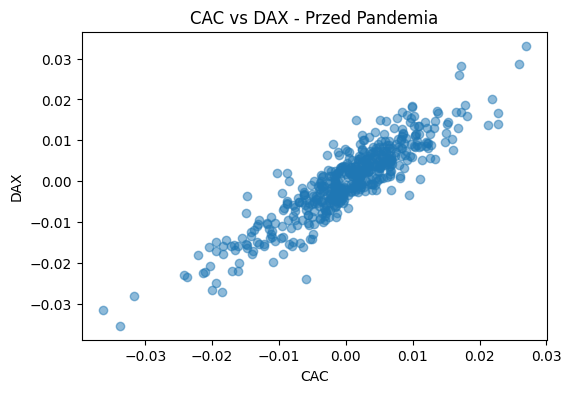

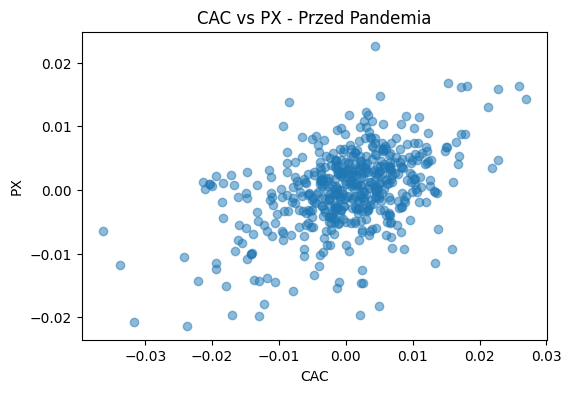

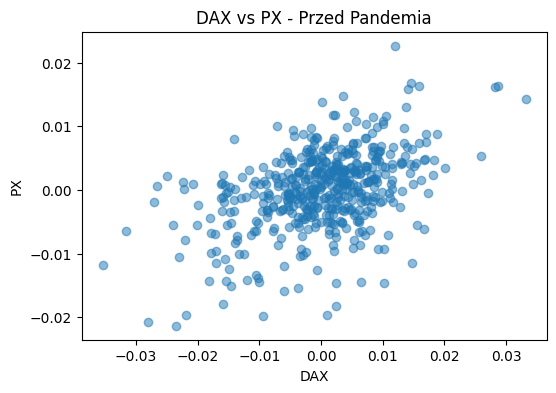

Correlations During Covid
          WIG       CAC       DAX        PX
WIG  1.000000  0.729851  0.731296  0.592678
CAC  0.729851  1.000000  0.948513  0.730667
DAX  0.731296  0.948513  1.000000  0.729297
PX   0.592678  0.730667  0.729297  1.000000


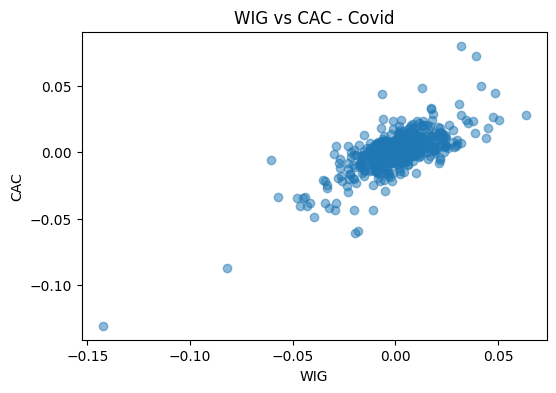

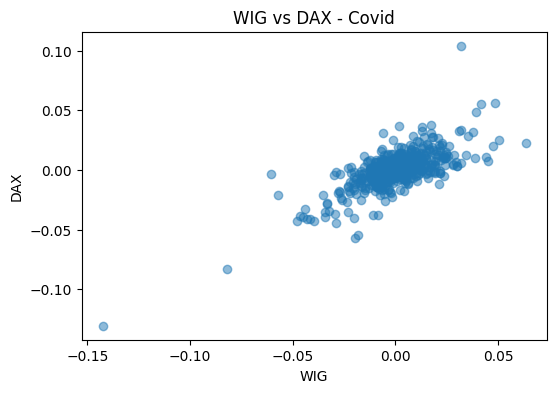

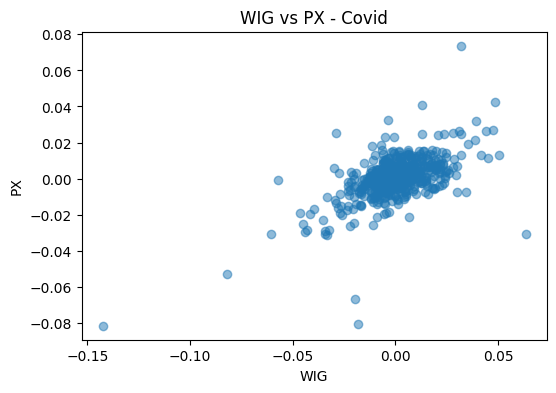

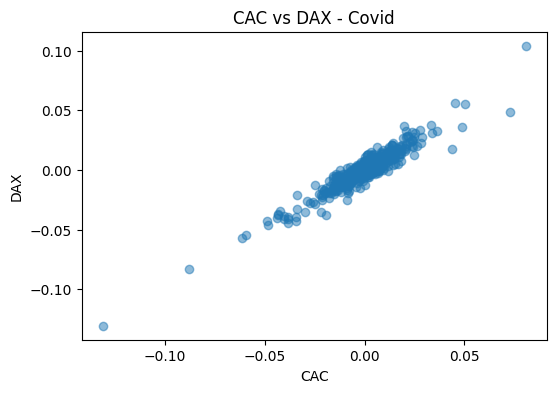

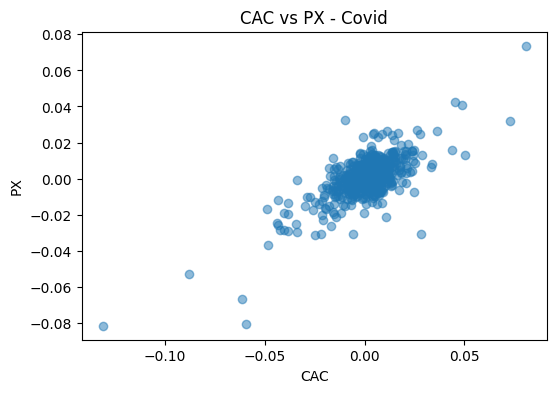

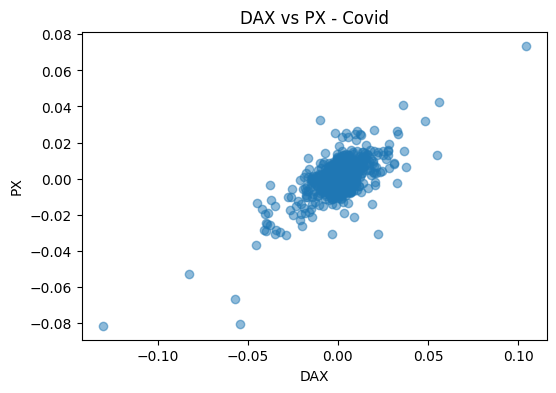

Correlations During Wojna
          WIG       CAC       DAX        PX
WIG  1.000000  0.574146  0.588091  0.411314
CAC  0.574146  1.000000  0.919948  0.473245
DAX  0.588091  0.919948  1.000000  0.479077
PX   0.411314  0.473245  0.479077  1.000000


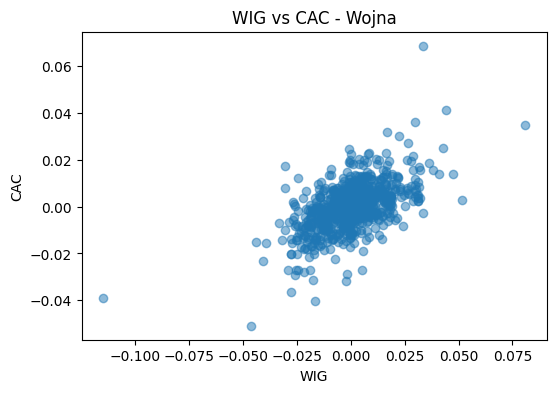

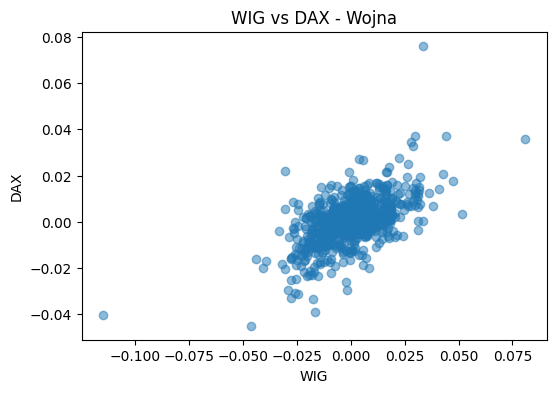

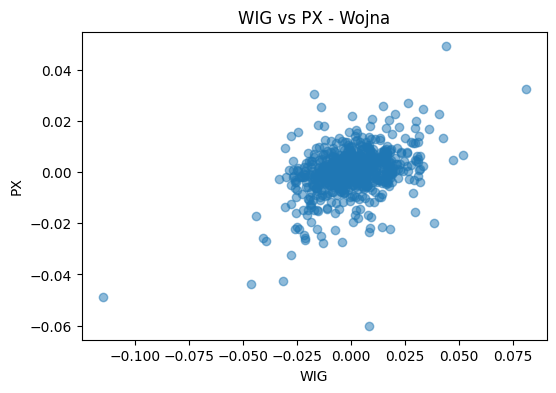

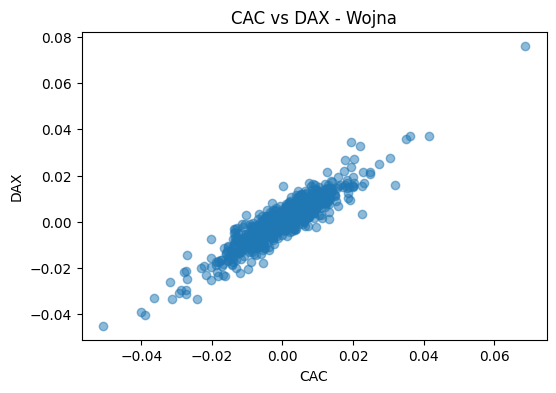

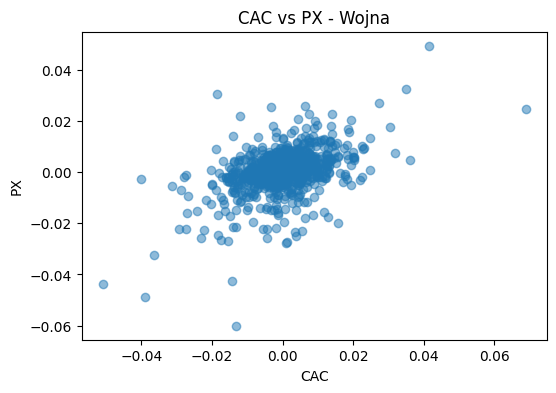

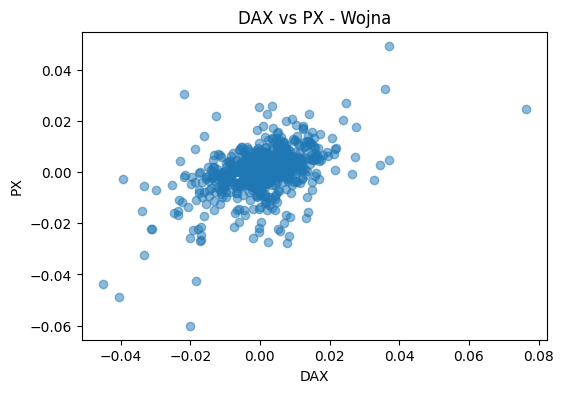

In [ ]:
# Obliczanie i wizualizacja korelacji dla każdego okresu
for period in ['przed_pandemia', 'covid', 'wojna']:
    print(f"Correlations During {period.replace('_', ' ').title()}")
    period_data = pd.concat(
        [wig_periods[period]['log_returns'], cac_periods[period]['log_returns'],
         dax_periods[period]['log_returns'], px_periods[period]['log_returns']], axis=1
    )
    period_data.columns = ['WIG', 'CAC', 'DAX', 'PX']
    correlations = period_data.corr()
    print(correlations)

    # Wykresy rozrzutu dla każdej pary rynków
    for pair in combinations(correlations.columns, 2):
        plt.figure(figsize=(6, 4))
        plt.scatter(period_data[pair[0]], period_data[pair[1]], alpha=0.5)
        plt.title(f'{pair[0]} vs {pair[1]} - {period.replace("_", " ").title()}')
        plt.xlabel(pair[0])
        plt.ylabel(pair[1])
        plt.show()


In [ ]:
# Korelacje w formie tabel
correlation_tables = {}
for period in ['przed_pandemia', 'covid', 'wojna']:
    print(f"Correlations During {period.replace('_', ' ').title()}")
    period_data = pd.concat(
        [wig_periods[period]['log_returns'],
         cac_periods[period]['log_returns'],
         dax_periods[period]['log_returns'],
         px_periods[period]['log_returns']], axis=1
    )
    period_data.columns = ['WIG', 'CAC', 'DAX', 'PX']
    correlations = period_data.corr()
    print(correlations)
    correlation_tables[period] = correlations


Correlations During Przed Pandemia
          WIG       CAC       DAX        PX
WIG  1.000000  0.506311  0.517730  0.432496
CAC  0.506311  1.000000  0.902793  0.465258
DAX  0.517730  0.902793  1.000000  0.450022
PX   0.432496  0.465258  0.450022  1.000000
Correlations During Covid
          WIG       CAC       DAX        PX
WIG  1.000000  0.729851  0.731296  0.592678
CAC  0.729851  1.000000  0.948513  0.730667
DAX  0.731296  0.948513  1.000000  0.729297
PX   0.592678  0.730667  0.729297  1.000000
Correlations During Wojna
          WIG       CAC       DAX        PX
WIG  1.000000  0.574146  0.588091  0.411314
CAC  0.574146  1.000000  0.919948  0.473245
DAX  0.588091  0.919948  1.000000  0.479077
PX   0.411314  0.473245  0.479077  1.000000
